2018 Edition

## Abstract
We will be using stacked ensemble models since diverse learner are good for some part of the data but not the entire part. Model stacking is an efficient ensemble method in which the predictions, generated by using various machine learning algorithms, are used as inputs in a second-layer learning algorithm. This second-layer algorithm is trained to optimally combine the model predictions to form a new set of predictions

## Outline of Our Notebook
* **1**\. **Exploratory Data Analysis**
    * **1.1\. Overall insight Data**
        * In this part we load into data frame and have a first glance on it
	* **1.2\. Statistic of target variable** 
		* We go deeper into a very important varible - the Sale Price by explore its distribution
	* **1.3\. Look into numeric variables**
		* We take a closer look on only numeric features by plotting their histogram
	* **1.4\. Relation between SalePrice and numerical variable**
	* **1.5\. Look into categorical varibles**

* **2**\. **Feature Engineering**
	* **2.1\. Target Variable Processing: Homoscedasticity** 
        * In this part, we take care the skewness of SalePrice
	* **2.2\. Numerical Variable Processing**
		* Consider correlation between numerical variables with SalePrice and remove some observable outliers
	* **2.3\. Imputing missing values**
		* Combine different method to fill the missing values
	* **2.4\. Categorical feature exploration**
		* Statistic on categorical features
	* **2.5\. Feature skewness**
		* Take care the skewed features
	* **2.6\. Feature encoding**
	* **2.7\. Adding new features**
	* **2.8\. Feature importance and degree adding**
		* Use Lasso coefficient the weight the importance of features
	* **2.9\. Removal of outliers**
		* Remove outliers using OLS one-step correction method
* **3**\. **Modeling and validation**
	* **3.1\. Individual models**
        * We try 8 different models such as Lasso, Elastic Net ... and measures their performances
	* **3.2\. Building a staked model**
        * Select the best of base model, stack them into one and use Lasso as a meta learner
	* **3.3\. Averaging staked model and ExtraGradientBoost**
        * Combine the stack model with xgboost
* **4**\. **Tuning parameters**
	* We tune the parameters for base learners as well as hyperparameters for the Lasso using a combination of grid search and bayesian optimization.




In [1]:
#Imports Cell
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
#from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold,train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import RobustScaler, StandardScaler
from bayes_opt import BayesianOptimization
import scipy as sp

warnings.filterwarnings('ignore')

# 1. Exploratory Data Analysis
the feature variables in the dataset roughly fall into two category, one is numerical variable and the other is Categorical Variables.

before find out how to utilise these data, we should do some exploratory on the data.
- The schemas, columns, shape, structure of data
- Statistic of target
- Statistic of category and numerical data like: the skewfeatures, outliers, correlation, etc


## 1.1 Overall Insight Data

In [2]:
train = pd.read_csv('challenge_data/train.csv')
test = pd.read_csv('challenge_data/test.csv')
print(train.get_dtype_counts())
print("the size of the training data:", train.shape)
print("the size of the test data:", test.shape)
train.head(5)

float64     3
int64      35
object     43
dtype: int64
the size of the training data: (1200, 81)
the size of the test data: (260, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### COMMENT 1.1
* As we can see, we have 80 feature for the house, and one column of "SalePrice" in training data.
* Some of them are numerical and some are categorical, and some of them have the "invalide" value "NaN"
* It means that, in order to fit a predict model,  we have to cast categorical to numerical and amend the invalide value, we will deal with this problem in "data processing" step

## 1.2 Statistic of Target Variable "SalePrice"
SalePrice is the variable we need to predict. So it is better to have a basic knowledge on its statistic first.

if there is NaN in saleprice:  False
count      1200.000000
mean     181414.628333
std       81070.908544
min       34900.000000
25%      129900.000000
50%      163700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
mean = 181414.63, :deviation =81037.12


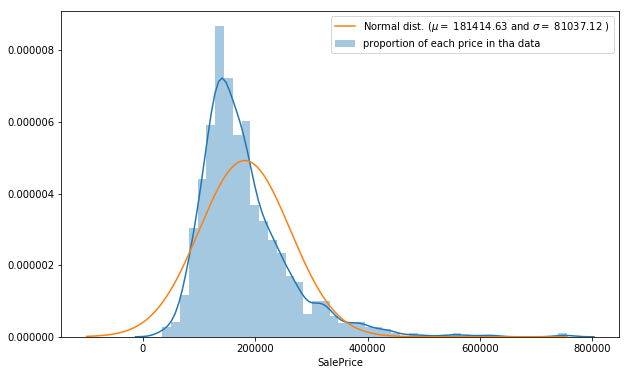

In [3]:
#print stats
SalePrice_mean, SalePrice_deviation = sp.stats.norm.fit(train['SalePrice'])
print("if there is NaN in saleprice: ",train['SalePrice'].isnull().any())
print(train['SalePrice'].describe())
print("mean = {:.2f}, :deviation ={:.2f}".format(SalePrice_mean,SalePrice_deviation))

# draw the histogram
plt.figure(figsize=(10,6))
sns.distplot(train['SalePrice'])

# draw fit norm distribution
x = np.linspace(-100000,max(train['SalePrice']),num = len(train['SalePrice']))
pdf = list(sp.stats.norm.pdf(x, loc=SalePrice_mean, scale=SalePrice_deviation))
plt.plot(x,pdf)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(SalePrice_mean, SalePrice_deviation),'proportion of each price in tha data'])
plt.show()

- compare with the distribution of SalePrice(blue) and a normal distribution(orrange) with the same $\mu$ and $\sigma$, we can find that our data is more skewed to the left and have a big tail in the right.    
- kind of look like a normal or lognormal distribution with a big tail
- so in order to check if our data obey a norm distribution with parameters(mean = 181414.63, deviation =81037.12), we decide to use the Q-Q plot to check the skewness of our data.

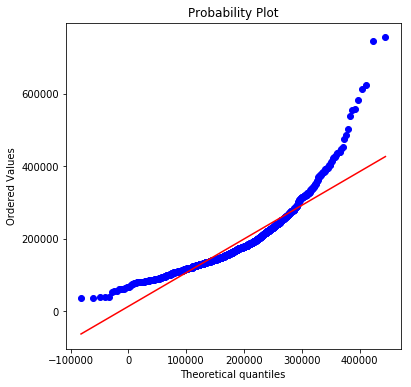

In [4]:
# Q-Q plot
fig = plt.figure(figsize=(6,6))
sp.stats.probplot(train['SalePrice'], sparams=(SalePrice_mean, SalePrice_deviation), dist='norm', plot = plt)
plt.show()

#### COMMENT 1.2
* the points dont fit the strange line very well, so it is not a norm dist strictly.
* and it is a upward curve, that means our saleprice data is little bit skewed toward left, positively skewed.
* on the top right, the points are hihger than the line, it means that out data has a big tail in the right, it is not a norm dist strictly.
* **So we should take this into account and try to use some method (like log-transform) to reduce the skewness when we go to training. **

## 1.3 Look Into Numeric Variables.
It also make sense to have a quick overall look into the histogram of the numeric feature, to have a basic idea of its distribution
- and drop Id (just index, meaningless) and saleprices itself
- and the "NaN" element in data could make some trouble when you try to use histogram function, and when we want to make prediction, so it also make sense to look into the "NaN" value in the data  ??? but how to deal with them when make our model put to "0"?

In [5]:
# find out the numeric features columns with a NaN 
df_train_numeric = train.select_dtypes(include=["float64","int64"]).drop(['Id', 'SalePrice'], axis=1)
df_train_numeric.columns[df_train_numeric.isnull().any()].tolist()

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

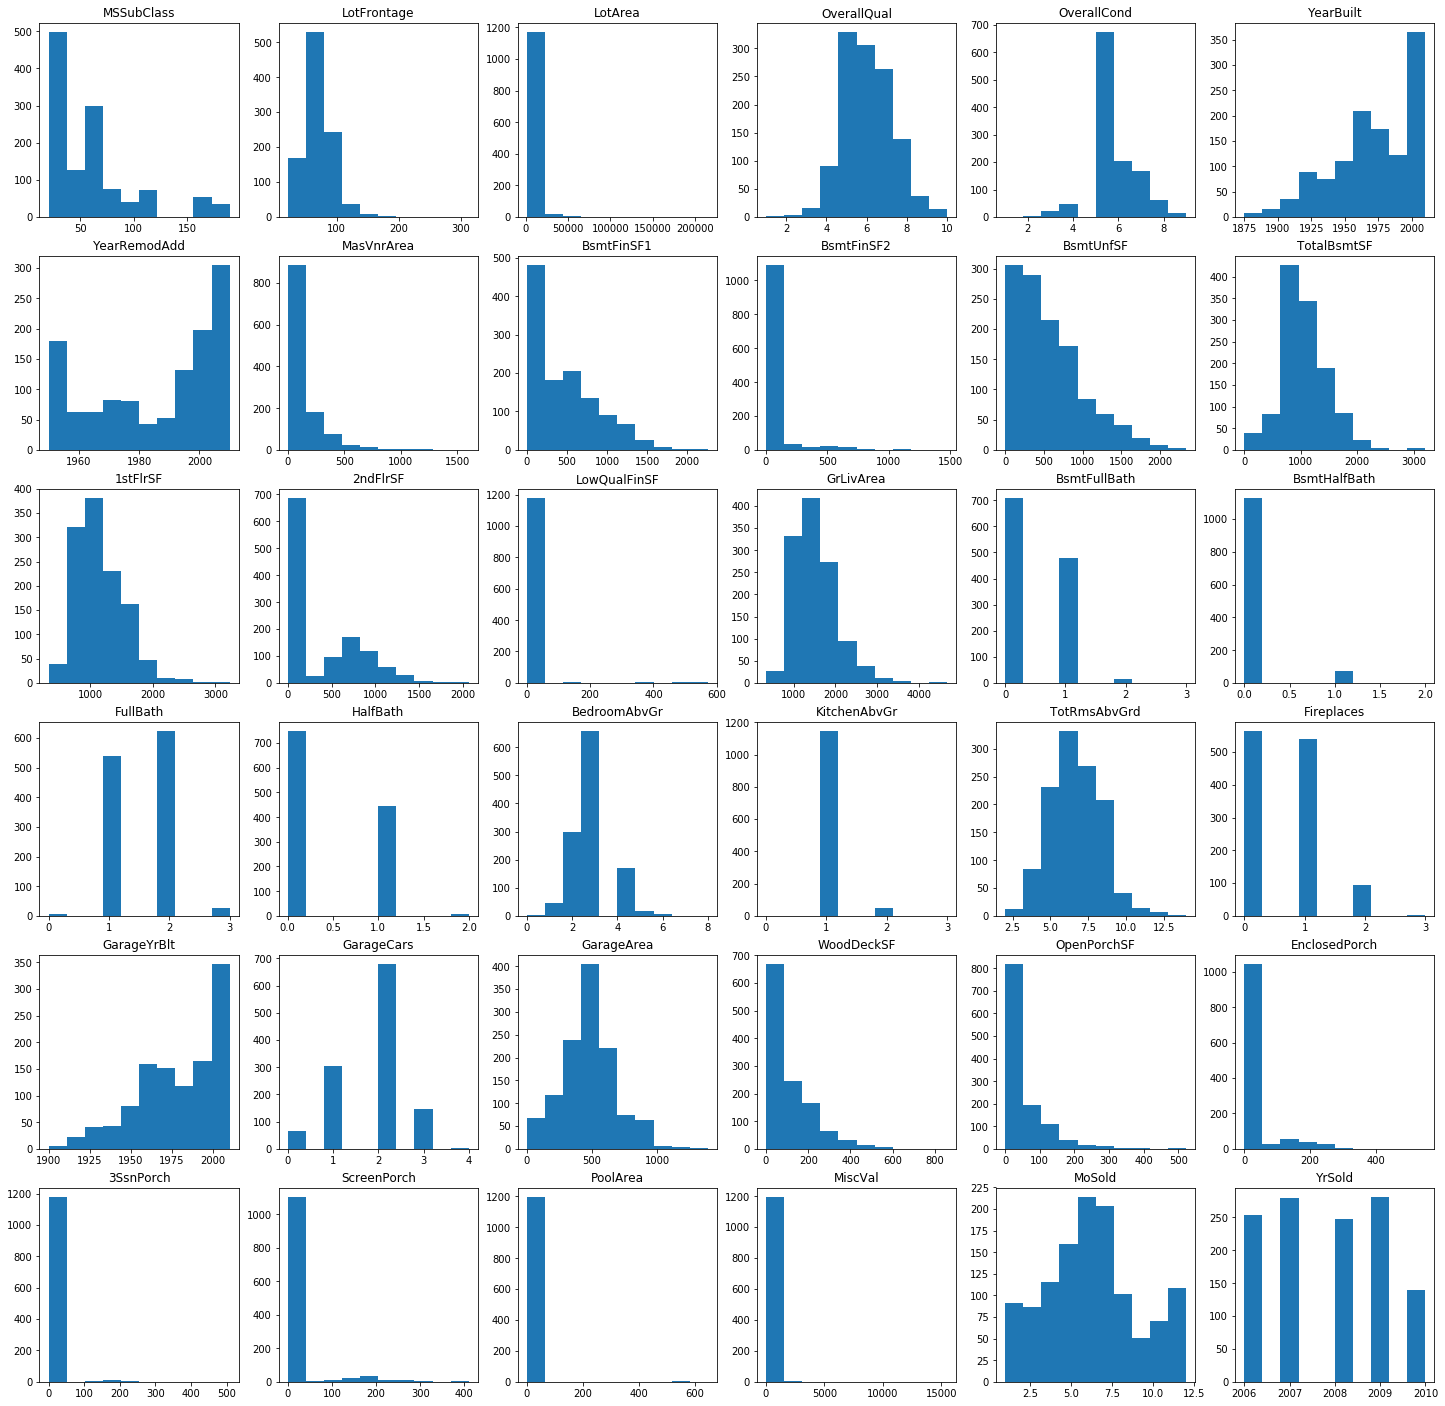

In [6]:
#plot histogram
columns = 6
rows = 6

fig, ax_array = plt.subplots(rows, columns,squeeze=False,figsize=(25, 25))
for i in range(36):
    plt.subplot(rows, columns, i+1)    
    plt.hist(df_train_numeric[df_train_numeric.columns[i]].dropna().values)
    plt.title(df_train_numeric[df_train_numeric.columns[i]].name)

plt.show()

#### COMMENT 1.3
* Here we only drop the NaN value for the convenient of ploting histogram to have overall data distribution insight, but when we build our model, the NaN may be treat in another way. 
* And from the graph above we can have that: the features have a various distribution:  
- Some of them are concentrate on few scattered values, and have serveral vales very significant while the others are very small(like **'GarageArea'**)
- Some of them are skewed on one side (like **'MSSubClass'**)
- Some of them are concentrate on only one value (like **'OverallCond'**)

## 1.4  Relation Between Sale Price and Numeriacal Features.
It makes sense we think that maybe some features have a stronger relationship with the sale price than the others. 

a scatter plot can give us a quick look on the pairwise relationships in our data.

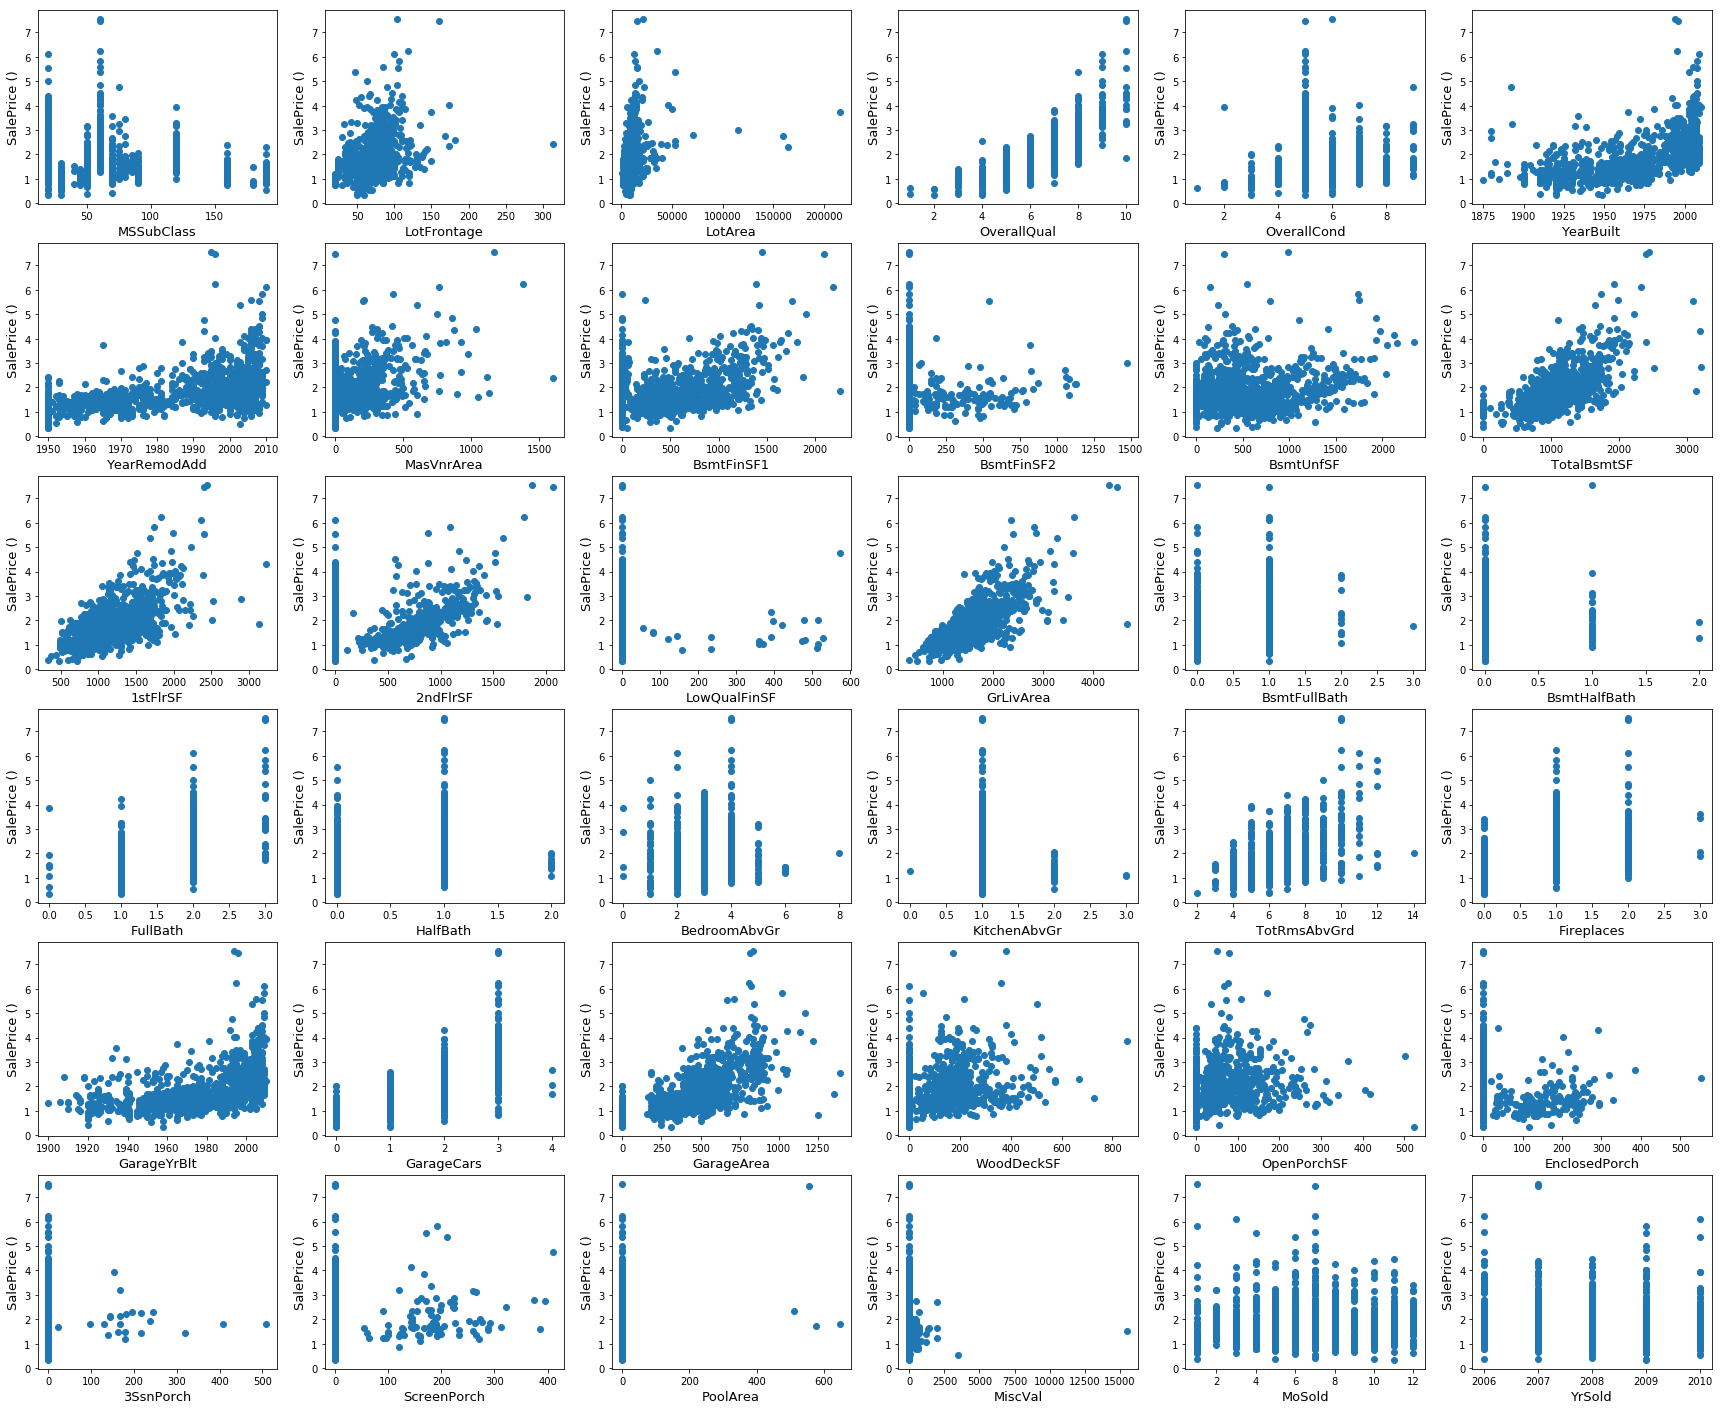

In [7]:
#plot histogram
columns = 6
rows = 6

fig, ax_array = plt.subplots(rows, columns,squeeze=False,figsize=(30, 25))
for i in range(36):
    plt.subplot(rows, columns, i+1)
    plt.scatter( df_train_numeric[df_train_numeric.columns[i]],train['SalePrice']/100000)
    plt.ylabel('SalePrice ()', fontsize=13)
    plt.xlabel(df_train_numeric[df_train_numeric.columns[i]].name, fontsize=13)


plt.show()

#### COMMENT 1.4
* from the graphs above we find that some features have a potential linear or exponential or other relationship with sale price, like the '**GrLivArea'**, and '**TotalBsmtSF'**.
* some features show that there maybe not link between it and saleprice like '**MoSold**'.

we can come back to these plots when we need to trim the number of feature.

## 1.5 Look Into Categorical Features.
now have a quick look into the categorical.

and since categorical features has less possible values, we could use box plot to look into its distibution.

In [8]:
# select categorical features and print those with NaN values
df_train_categorical = train.select_dtypes(include=["object"])
df_train_categorical.columns[df_train_categorical.isnull().any()].tolist()

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

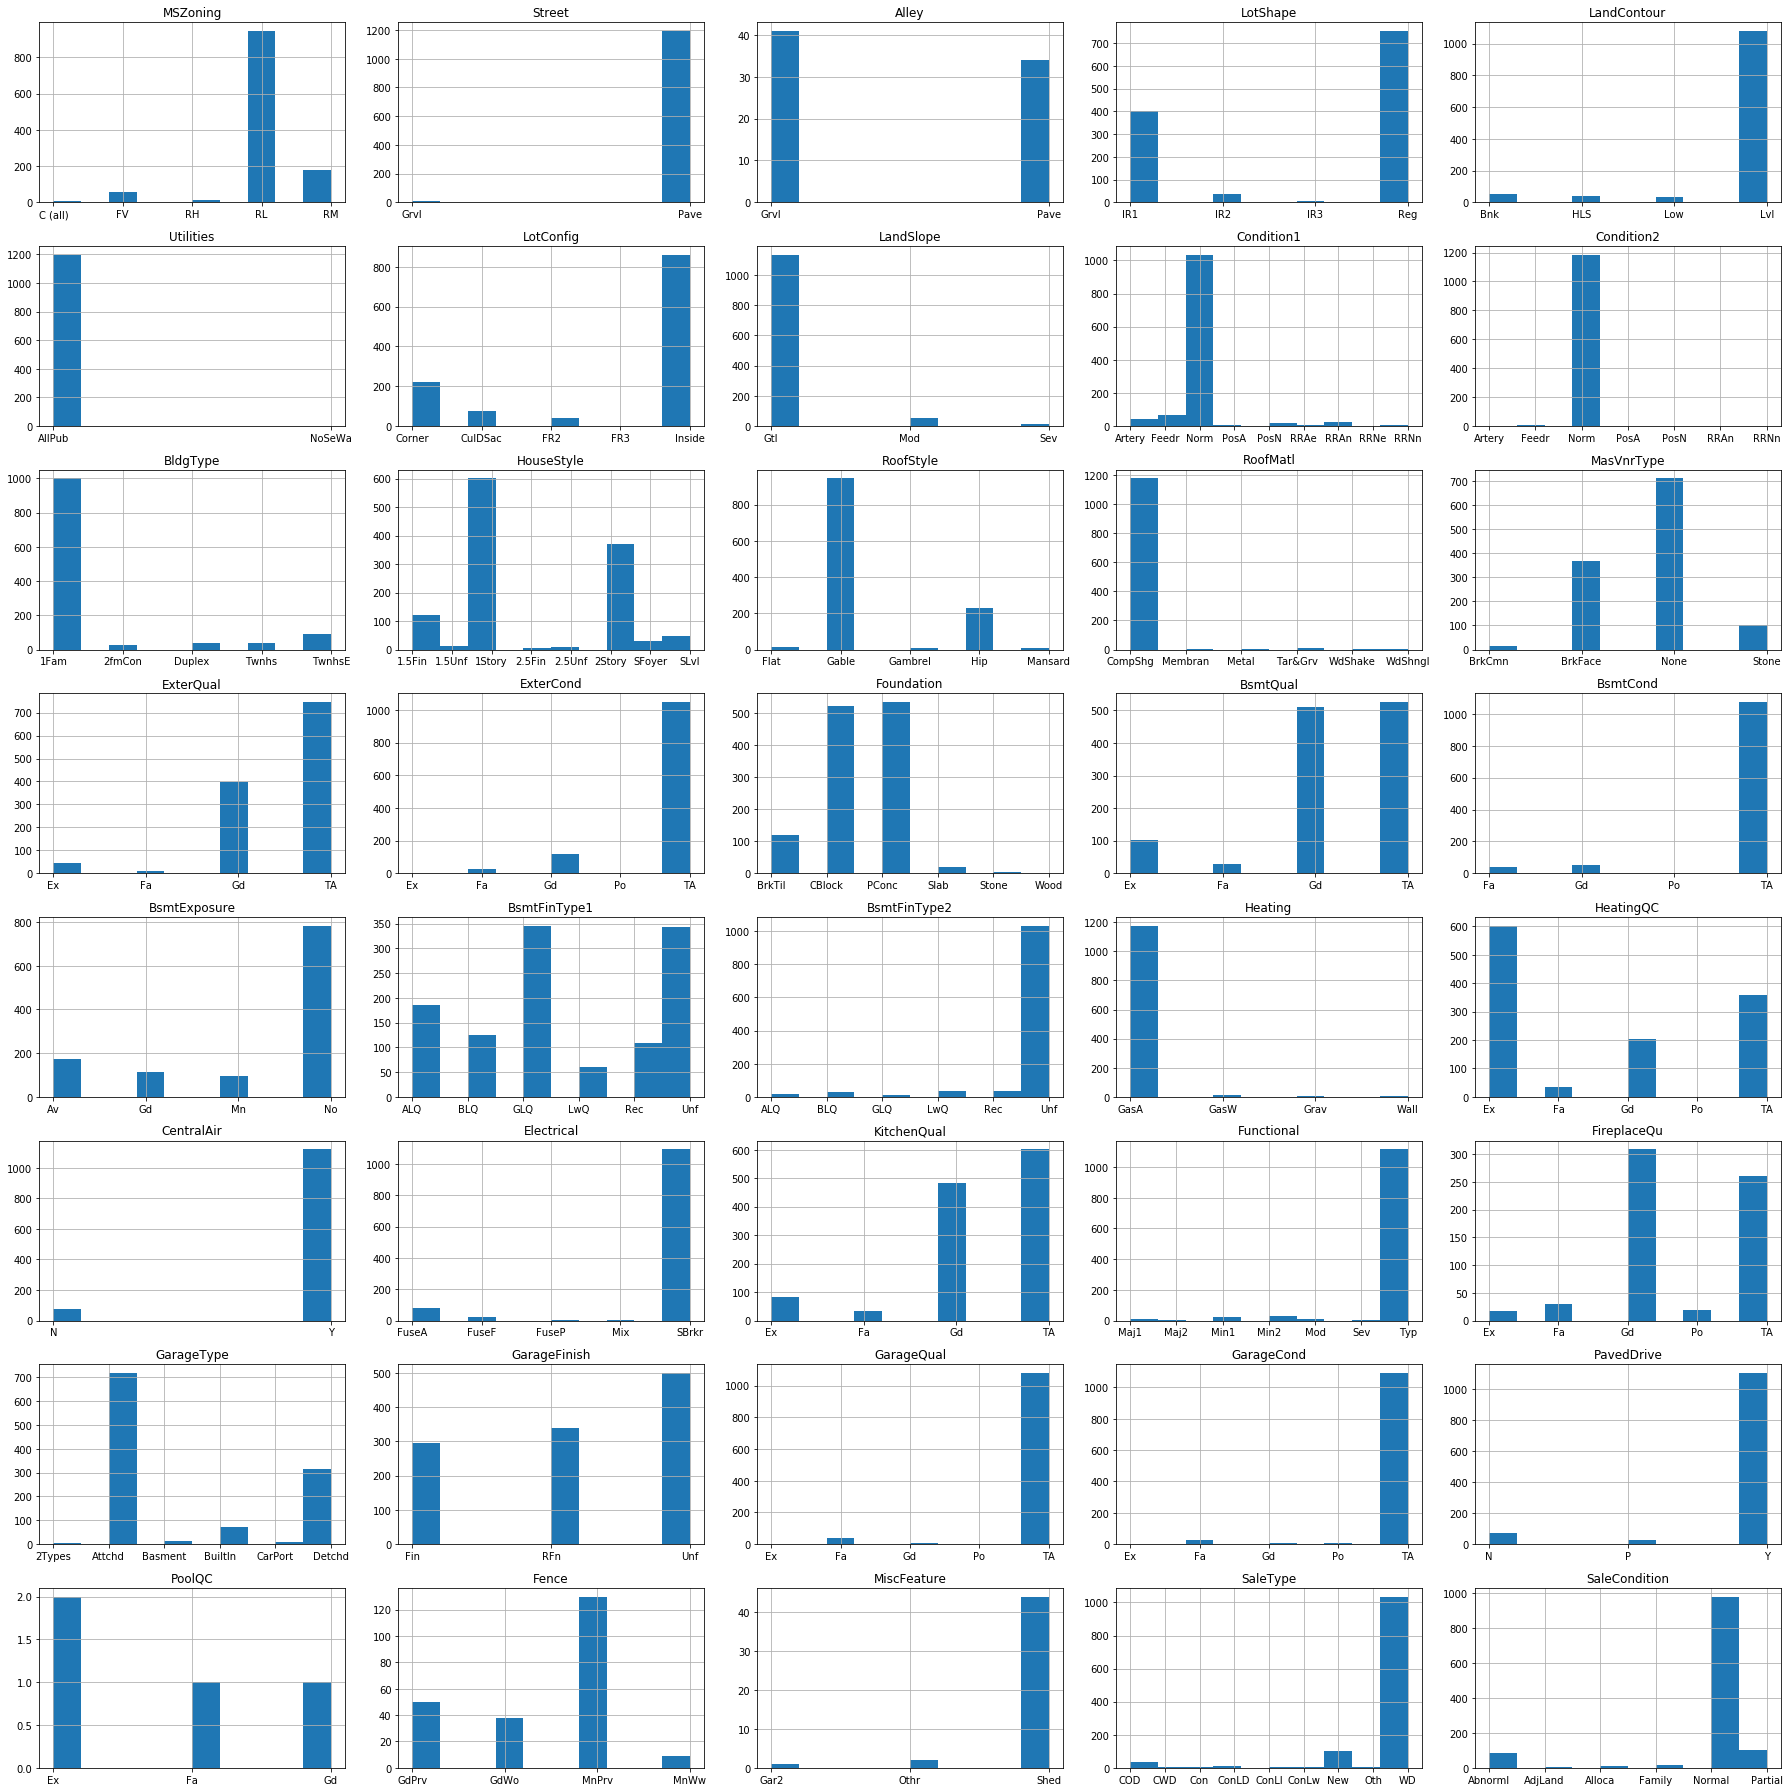

In [9]:
# histogram for categorical features
fig, ax_lst = plt.subplots(8, 5,figsize=(25, 25))
df_train_categorical_small = df_train_categorical.drop(['Exterior1st','Exterior2nd','Neighborhood'], axis=1)
for i, ax_row in enumerate(ax_lst):
    for j,ax_j in enumerate(ax_row):
#         ax_i = df_train_categorical['BsmtFinType1'].hist()
        if i*5 +j < 43:
            df_train_categorical_small[df_train_categorical_small.columns[i*5 +j]].hist(ax = ax_j)
            ax_j.set_title(df_train_categorical_small[df_train_categorical_small.columns[i*5 +j]].name)
plt.tight_layout()
plt.show()                           

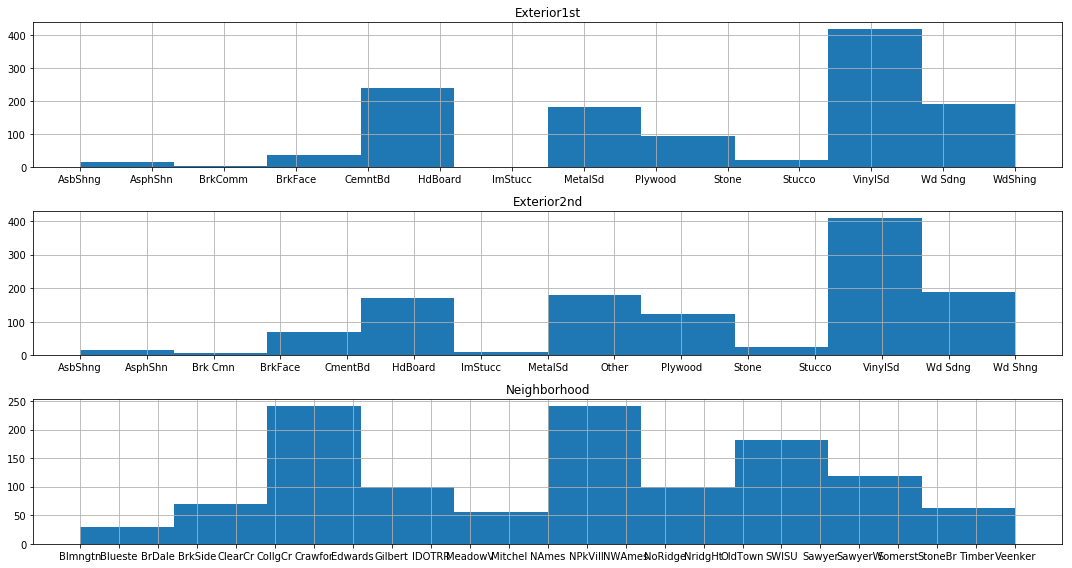

In [10]:
# three features have more possible values, we plot it separately to have a better presentation
fig, ax_lst = plt.subplots(3, 1,figsize=(15, 8))
df_train_categorical_long = df_train_categorical[['Exterior1st','Exterior2nd','Neighborhood']]
for i, ax_row in enumerate(ax_lst):
#         ax_i = df_train_categorical['BsmtFinType1'].hist()
        df_train_categorical_long[df_train_categorical_long.columns[i]].hist(ax = ax_row)
        ax_row.set_title(df_train_categorical_long[df_train_categorical_long.columns[i]].name)
plt.tight_layout()
plt.show()

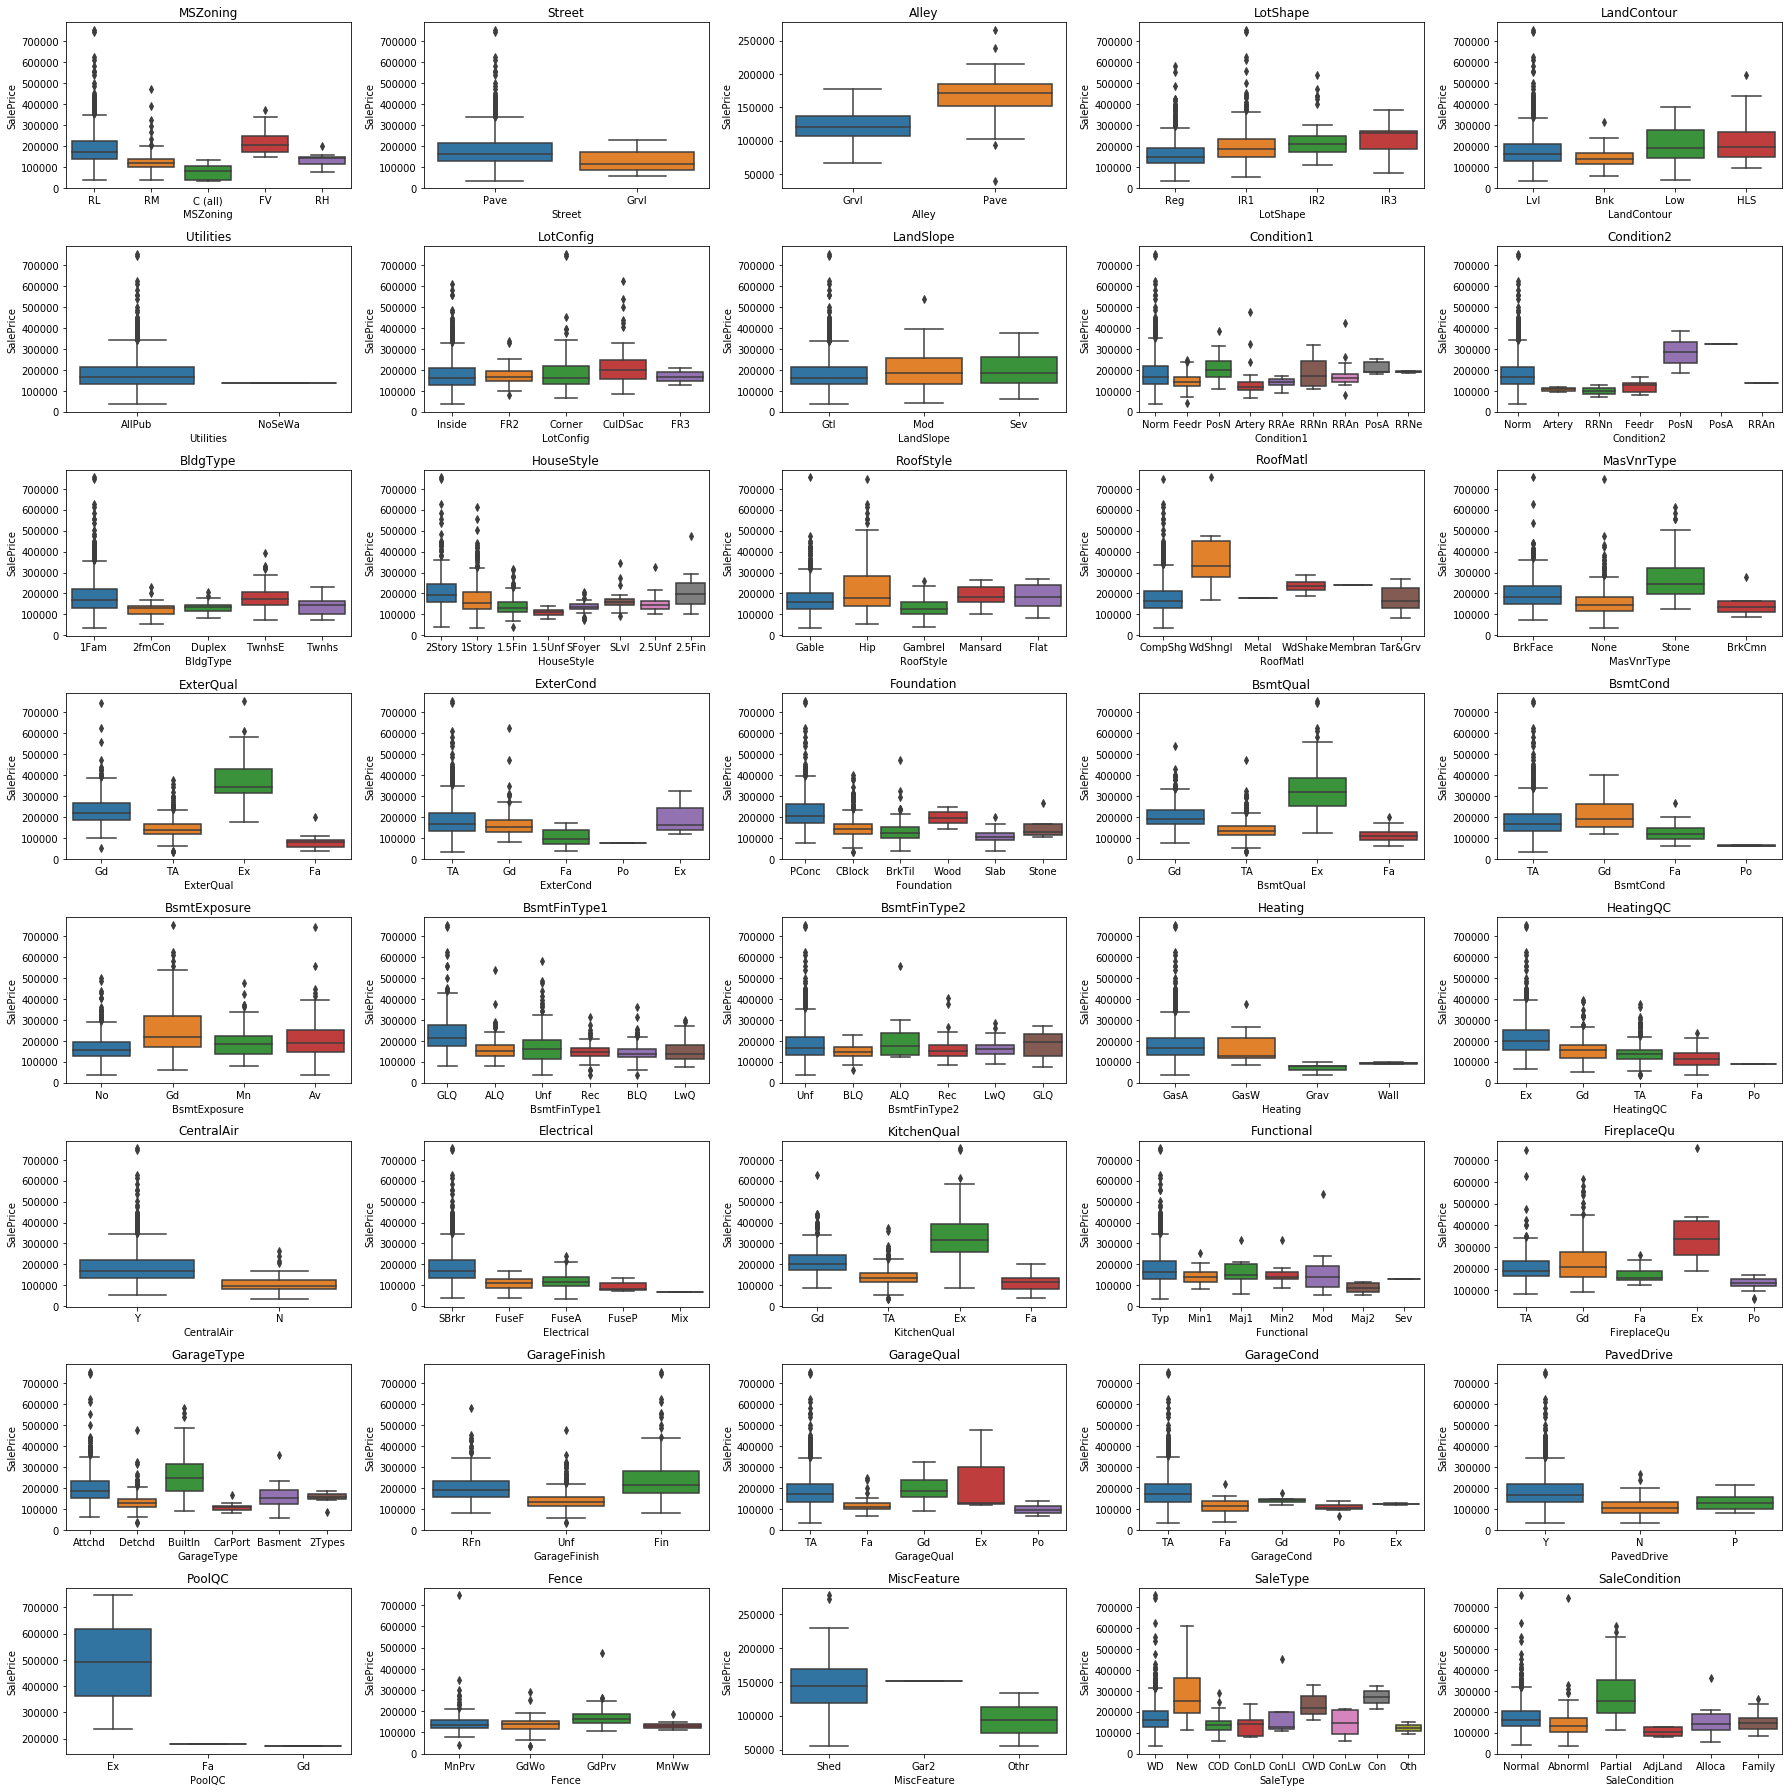

In [11]:
# boxplot for categorical features
fig, ax_lst = plt.subplots(8, 5,figsize=(25, 25))
df_train_categorical_small = df_train_categorical.drop(['Exterior1st','Exterior2nd','Neighborhood'], axis=1)
for i, ax_row in enumerate(ax_lst):
    for j,ax_j in enumerate(ax_row):
#         ax_i = df_train_categorical['BsmtFinType1'].hist()
        if i*5 +j < 43:
#             df_train_categorical_small[df_train_categorical_small.columns[i*5 +j]].hist(ax = ax_j)
            ax_j.set_title(df_train_categorical_small[df_train_categorical_small.columns[i*5 +j]].name)
            data = pd.concat([train['SalePrice'], df_train_categorical_small[df_train_categorical_small.columns[i*5 +j]]], axis=1)
            fig = sns.boxplot(x=df_train_categorical_small.columns[i*5 +j], y="SalePrice", data=data, ax = ax_j)
plt.tight_layout()
plt.show()     

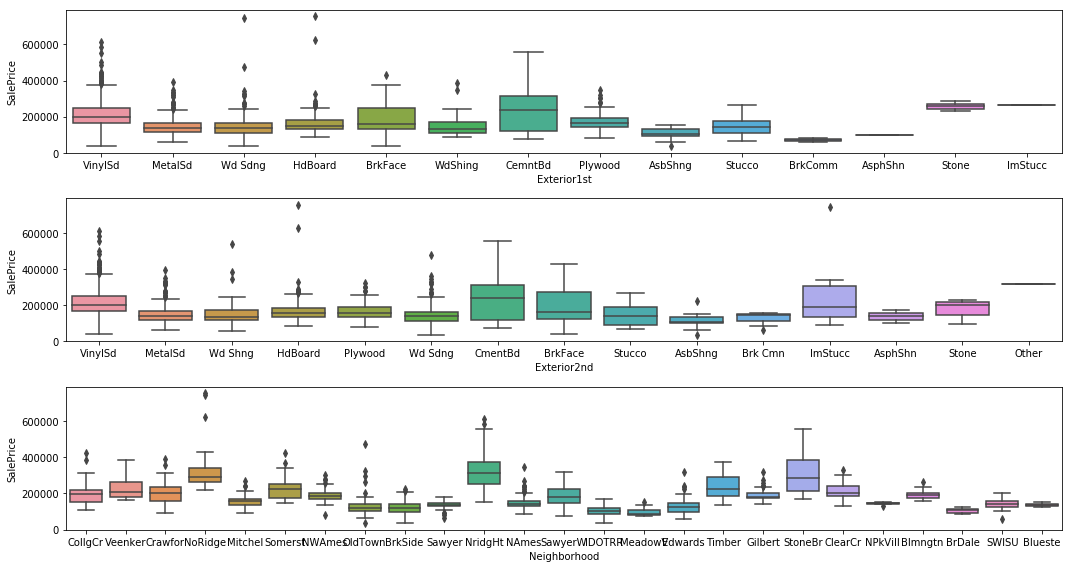

In [12]:
# three features have more possible values, we plot it separately to have a better presentation
fig, ax_lst = plt.subplots(3, 1,figsize=(15, 8))
for i, ax_row in enumerate(ax_lst):        
        ax_j.set_title(df_train_categorical_long[df_train_categorical_long.columns[i]].name)
        data = pd.concat([train['SalePrice'], df_train_categorical_long[df_train_categorical_long.columns[i]]], axis=1)
        fig = sns.boxplot(x=df_train_categorical_long.columns[i], y="SalePrice", data=data, ax = ax_row)
plt.tight_layout()
plt.show()

#### COMMENT 1.5
* from the histogram we can find that similar as the numerical features, the many categorical features concentrate on one or two values, leave the others may not have enough data, like **'GarageCond'** and **'Functional'**
* but from the boxplot, in many features, there is a meaningful relationship between its values and sale price, like in **'ExterQual'**, different values of this feature would lead to a different major quantile of the sale price (**'interquartile range(IQR)'** and **'median'**), 
* this show that it has impact on the price, but it is hard to be interpreted as a linear or exponential relationship like in the numerical features. so in our model we should find a good way to interpreted the influence of different values.
* but some features also show that they may not suitable to be used in the model, like the **'PoolQC'**, most data fall in one single value 'Ex', and it cover a wide range of the possible saleprice from 4000000 to 6000000, it is hard for us to extract relationship between salsprice and the different value of 'PoolQC', **so we may use the boxplot when we want to trim the data"**

we can come back to these plots when we need to trim the number of feature.

# 2. Feature Engineering
after having a overall insight of our data, we start to prepare data to make them suitable for the possible model.
here we will focus on deal with:
- Fill missing data (**We fill with either 'None' or the most common value or use polyfit to predict missing value**)
- Transform the skewed features
- Remove outliers 
- Adding some more features
- Do the label encoding
- Do feature selection





## 2.1 Target Variable Processing: Homoscedasticity
we have seen in "step 1.2" that the sale price have a positive skewed feature and have a "big" tail, so can not be fitted into a normal distribution. But in order to make the error smaller, we hope that **dependent variable(s) exhibit equal levels of variance across the range of predictor variable, which is called Homoscedasticity problem.** 

Like in our case sale price is not normal, we can see in the "step 1.4" in the graph of GrLivArea vs. SalePrice, we see that this scatter plot has a conic shape, it would lead to vary variance across the range of predictor variable. However we can solve this problem by solving normality of target variable.

from "step 1.2", SalePrice positive skewness and does not follow the diagonal line, so we can apply a **log transformation**. 




 mu = 12.02 and sigma = 0.40



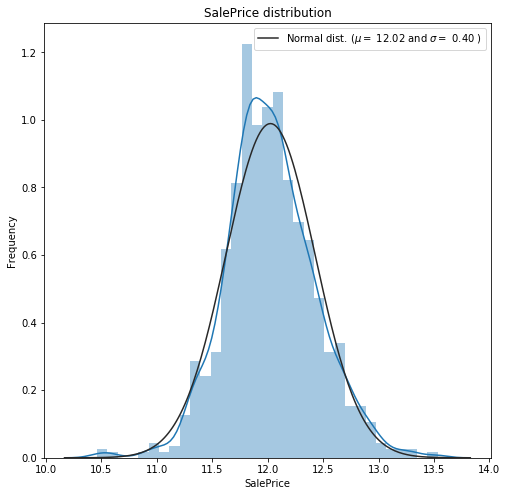

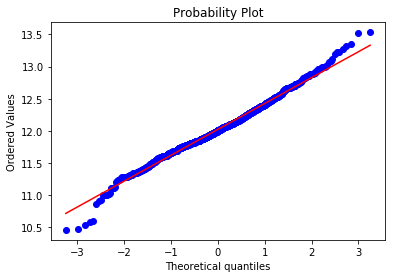

In [13]:
# plot and check the new distribution of SalePrice
plt.figure(figsize=(8,8))
sns.distplot(np.log1p(train['SalePrice']), fit=sp.stats.norm)
# compute (mean, sigma)
(mean, sigma) = sp.stats.norm.fit(np.log1p(train['SalePrice']))
                                  
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mean, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mean, sigma)],loc='best')
plt.ylabel("Frequency")
plt.title('SalePrice distribution')
# use QQ-plot to check
fig = plt.figure()
res = sp.stats.probplot(np.log1p(train['SalePrice']), plot=plt)
plt.show()

In [14]:
train['logSalePrice']=np.log1p(train['SalePrice'])

## 2.2 Numerical Variable Processing

* First look into its correlation. Correlation matrix + heatmap is a good way for us to find out the relationship between one feature and our target, as well as its covariance with others features. we can use this information to find out some high correlation or redundency, and may according to these to select features.

here we: 
* 1.plot the whole correlation matrix
* 2.find out features whoes correlation with saleprice is bigger than a **threshold.**
* 3.find out that strongly correlated features, since they maybe introduce redundency info.



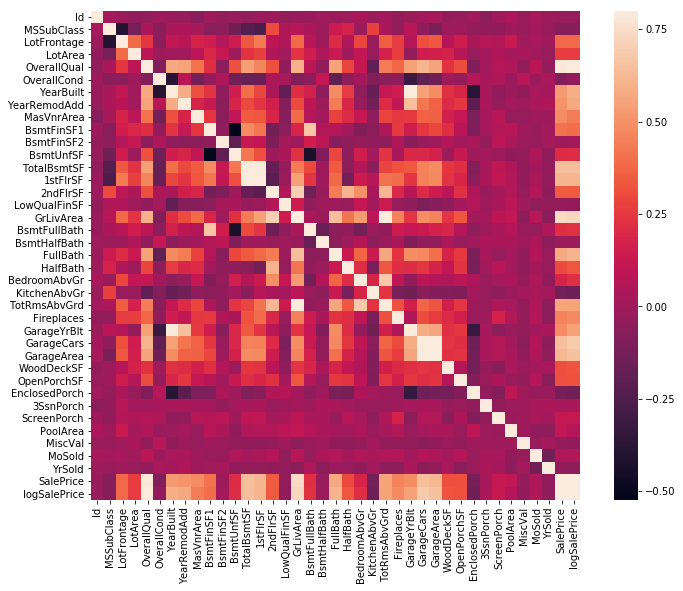

In [15]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

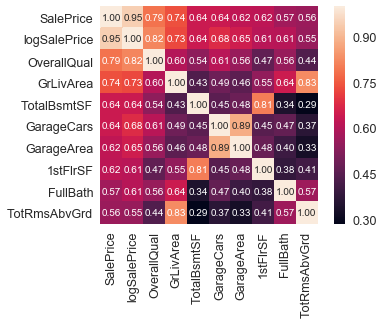

In [16]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### comment:

1.'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice', with the correlation bigger than 0.

2.here we can also find out that inside the highly corelative features, those pairs:
* (1stFlrSF, TotalBsmtSF)
* (GarageArea, GarageCars)
* (YearBuilt, GarageYrBlt)
* (GrLivArea, TotRmsAbvGrd)

them tend to give similar infomation, and it is true when we look into the description of these variabl, like: number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers.

3.when we try to tune the model by use different selections of features, we will come back to this part to use information there.

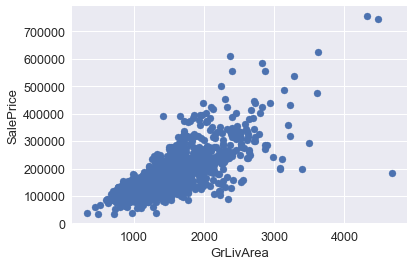

(1200, 82)

In [17]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()
train.shape

#### Comment
Outliers removal is not always safe. We decided to delete the point in down-right corner as its very huge and really bad ( extremely large areas for very low prices).

Infact there can be more outliers after adding some more features and we will tackle them later using OLS bonferroni correction to test more outliers.

In [18]:
outlier_index = train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index
print('outlier index:', outlier_index)
train.drop(outlier_index,inplace=True)


outlier index: Int64Index([523], dtype='int64')


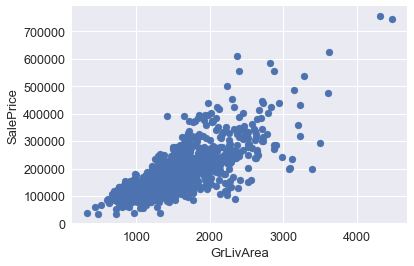

(1199, 82)

In [19]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()
train.shape

In [20]:
#put train and test data together for doing data processing
entire_data=pd.concat((train, test)).reset_index(drop=True)
print (entire_data.shape)

(1459, 82)


## 2.3 Imputing missing values
* one important metric here is the missing rate of feature. if we try to impute values for a high missing rate feature, we may introduce some bias, but we ignore them directly we may also suffer from loss some convenient truth.

* here we first decide to keep all the features and then impute the missing values according to the meaning of this varaiable. 
* we could also choose to delete some variable with high missing rate or having the same information with other features, we will do this part after we first try out the result of using all the feature.

In [21]:
#statistic on missing values
missing_val=entire_data.isnull().sum()
missing_val.sort_values(ascending=False)

PoolQC           1452
MiscFeature      1405
Alley            1368
Fence            1178
FireplaceQu       690
logSalePrice      260
SalePrice         260
LotFrontage       259
GarageQual         81
GarageFinish       81
GarageCond         81
GarageYrBlt        81
GarageType         81
BsmtFinType2       38
BsmtExposure       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrType          8
MasVnrArea          8
Electrical          1
Condition2          0
BldgType            0
2ndFlrSF            0
3SsnPorch           0
BedroomAbvGr        0
GarageCars          0
GarageArea          0
Functional          0
FullBath            0
                 ... 
SaleCondition       0
SaleType            0
ScreenPorch         0
Street              0
TotRmsAbvGrd        0
TotalBsmtSF         0
Utilities           0
WoodDeckSF          0
YearBuilt           0
YearRemodAdd        0
OverallCond         0
Neighborhood        0
HalfBath            0
MoSold              0
YrSold    

#### Comment
* For most of the cases we can see that according to the data description it means that there is no presence of the feature for a given house so we will fill it with 'None'.
* We also see that if there is no Masion veener type,there is no value for MasVnrArea which makes sense and so we fill it with zero.
* We fill the NA values in Electrical with the mode that is the most common value as there is only one with missing value.
  For 'LotFrontage' we have a lot many missing value so we use the most correlated feature to it i.e.-'LotArea' and use a polyfit to predict the Missing values.

In [22]:
None_cols = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType","GarageYrBlt"]

for col in None_cols:
    entire_data[col].fillna("None", inplace=True)

entire_data['MasVnrArea'].fillna(0,inplace=True)

#replace the missing value with the majority
entire_data['Electrical'].fillna(entire_data['Electrical'].mode()[0], inplace=True)

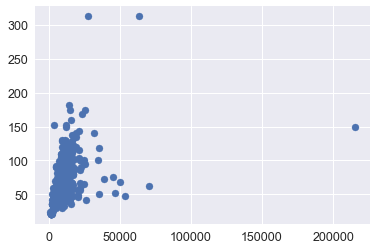

In [23]:
x = entire_data.loc[np.logical_not(entire_data["LotFrontage"].isnull()), "LotArea"]
y = entire_data.loc[np.logical_not(entire_data["LotFrontage"].isnull()), "LotFrontage"]
plt.scatter(x, y)
t = (x <= 25000) & (y <= 300)
p = np.polyfit(x[t], y[t], 1)
entire_data.loc[entire_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, entire_data.loc[entire_data['LotFrontage'].isnull(), 'LotArea'])

#### Comment
We convert some numerical features into string to turn them to categorical as according to the data description they are categorical.


In [24]:
#some numerical features are actually categorical
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YearRemodAdd","LowQualFinSF"]
for col in NumStr:
    entire_data[col]=entire_data[col].astype(str)

## 2.4 Categorical feature exploration

In this part, we do the statistic on the number of unique values each feature has. We decide to take a closer look on feature which have only 2 or 3 distinct values.


In [25]:
objects3 = []
for i in entire_data.columns:
    if entire_data[i].dtype == object:
        objects3.append(i)

sums_features = entire_data[objects3].astype(str).apply(lambda x: len(np.unique(x)))

print("No. of unique values\n", sums_features.sort_values(ascending=False))

No. of unique values
 GarageYrBlt      98
YearRemodAdd     61
Neighborhood     25
LowQualFinSF     24
Exterior2nd      16
Exterior1st      15
MSSubClass       15
MoSold           12
Condition1        9
SaleType          9
HouseStyle        8
RoofMatl          8
Condition2        8
BedroomAbvGr      8
GarageType        7
BsmtFinType1      7
Functional        7
BsmtFinType2      7
Foundation        6
SaleCondition     6
RoofStyle         6
Heating           6
GarageQual        6
FireplaceQu       6
GarageCond        6
BldgType          5
BsmtQual          5
Electrical        5
ExterCond         5
MiscFeature       5
Fence             5
MSZoning          5
BsmtExposure      5
BsmtCond          5
LotConfig         5
HeatingQC         5
LandContour       4
GarageFinish      4
LotShape          4
MasVnrType        4
ExterQual         4
BsmtFullBath      4
PoolQC            4
KitchenAbvGr      4
KitchenQual       4
Alley             3
BsmtHalfBath      3
HalfBath          3
LandSlope         

In [26]:
print('-------------------------------------')
print(entire_data['Street'].value_counts())
print('-------------------------------------')
print(entire_data['Utilities'].value_counts())
print('-------------------------------------')
print(entire_data['CentralAir'].value_counts())
print('-------------------------------------')
print(entire_data['PavedDrive'].value_counts())
print('-------------------------------------')
print(entire_data['Alley'].value_counts())
print('-------------------------------------')
print(entire_data['LandSlope'].value_counts())
print('-------------------------------------')
print(entire_data['BsmtHalfBath'].value_counts())
print('-------------------------------------')
print(entire_data['HalfBath'].value_counts())

-------------------------------------
Pave    1453
Grvl       6
Name: Street, dtype: int64
-------------------------------------
AllPub    1458
NoSeWa       1
Name: Utilities, dtype: int64
-------------------------------------
Y    1364
N      95
Name: CentralAir, dtype: int64
-------------------------------------
Y    1339
N      90
P      30
Name: PavedDrive, dtype: int64
-------------------------------------
None    1368
Grvl      50
Pave      41
Name: Alley, dtype: int64
-------------------------------------
Gtl    1381
Mod      65
Sev      13
Name: LandSlope, dtype: int64
-------------------------------------
0    1377
1      80
2       2
Name: BsmtHalfBath, dtype: int64
-------------------------------------
0    913
1    534
2     12
Name: HalfBath, dtype: int64


After doing the statistics, we realize that in case of **Utilities** and **Street**, **99.90%** of data of same class so we decide to drop those features.

In [27]:
entire_data = entire_data.drop(['Utilities', 'Street'], axis=1)

## 2.5 Feature skewness

In this part,we are going to exam the features skewness and decide which one we need to tranform them since skewness is not good for prediction

In [28]:
numeric_features = entire_data.dtypes[entire_data.dtypes != "object"].index
skewed_features = entire_data[numeric_features].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness


Skew in numerical features: 



,Skew
MiscVal,24.443278
PoolArea,14.807992
LotArea,12.290047
3SsnPorch,10.290132
LotFrontage,9.030113
BsmtFinSF2,4.249219
ScreenPorch,4.116334
EnclosedPorch,3.085342
MasVnrArea,2.684793
OpenPorchSF,2.332930


#### Comment
- We decide to do the **Box Cox transform** for features that have the absolute skewness greater than 0.75.
- We were not applying to **TotalBsmSF** because it made the skewness even worst

In [29]:
import scipy as sp
skewness = skewness[abs(skewness) > 0.75].dropna()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    if(feat not in ['TotalBsmtSF','Id','SalePrice']):
        entire_data[feat] = sp.special.boxcox1p(entire_data[feat], lam)
  

There are 18 skewed numerical features to Box Cox transform


In [30]:
# check the new skewness
new_skewed_features = entire_data[numeric_features].apply(lambda x : sp.stats.skew(x.dropna())).sort_values(ascending=False)
print("\nnew_Skew in numerical features: \n")
new_skewness = pd.DataFrame({'Skew' :new_skewed_features})
new_skewness


new_Skew in numerical features: 



,Skew
PoolArea,14.358427
3SsnPorch,7.825015
MiscVal,5.503462
ScreenPorch,3.183036
BsmtFinSF2,2.618092
EnclosedPorch,2.159803
SalePrice,1.964044
TotalBsmtSF,1.493074
LotArea,0.744180
OverallCond,0.691340


## 2.6 Feature encoding
Over here we assign an arrange the values of the ordinal data as we think maintaing the order maybe important.

In [31]:
id_data=entire_data['Id']
log_sp=entire_data['logSalePrice']
entire_data = entire_data.drop(['Id', 'logSalePrice'], axis=1)

In [32]:
entire_data = entire_data.replace({"Alley" : {"None":0,"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       }
                     )

## 2.7 Adding new features

We add new features to increase the accuracy more but one can argue that increasing the more number of features means that we are trying to fit more accuractely to the training set which may lead to overfitting but later we try using regularization models like lasso to prevent it.

In [33]:
entire_data['haspool'] = entire_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
entire_data['has2ndfloor'] = entire_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
entire_data['hasgarage'] = entire_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
entire_data['hasbsmt'] = entire_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
entire_data['hasfireplace'] = entire_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [34]:
# Create new features
# 1* Simplifications of existing features
entire_data["SimplOverallQual"] = entire_data.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
entire_data["SimplOverallCond"] = entire_data.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
entire_data["SimplPoolQC"] = entire_data.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
entire_data["SimplGarageCond"] = entire_data.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
entire_data["SimplGarageQual"] = entire_data.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
entire_data["SimplFireplaceQu"] = entire_data.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
entire_data["SimplFireplaceQu"] = entire_data.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
entire_data["SimplFunctional"] = entire_data.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
entire_data["SimplKitchenQual"] = entire_data.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
entire_data["SimplHeatingQC"] = entire_data.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
entire_data["SimplBsmtFinType1"] = entire_data.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
entire_data["SimplBsmtFinType2"] = entire_data.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
entire_data["SimplBsmtCond"] = entire_data.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
entire_data["SimplBsmtQual"] = entire_data.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
entire_data["SimplExterCond"] = entire_data.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
entire_data["SimplExterQual"] = entire_data.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
entire_data["OverallGrade"] = entire_data["OverallQual"] * entire_data["OverallCond"]
# Overall quality of the garage
entire_data["GarageGrade"] = entire_data["GarageQual"] * entire_data["GarageCond"]
# Overall quality of the exterior
entire_data["ExterGrade"] = entire_data["ExterQual"] * entire_data["ExterCond"]
# Overall kitchen score
entire_data["KitchenScore"] = entire_data["KitchenAbvGr"] * entire_data["KitchenQual"]
# Overall fireplace score
entire_data["FireplaceScore"] = entire_data["Fireplaces"] * entire_data["FireplaceQu"]
# Overall garage score
entire_data["GarageScore"] = entire_data["GarageArea"] * entire_data["GarageQual"]
# Overall pool score
entire_data["PoolScore"] = entire_data["PoolArea"] * entire_data["PoolQC"]
# Simplified overall quality of the house
entire_data["SimplOverallGrade"] = entire_data["SimplOverallQual"] * entire_data["SimplOverallCond"]
# Simplified overall quality of the exterior
entire_data["SimplExterGrade"] = entire_data["SimplExterQual"] * entire_data["SimplExterCond"]
# Simplified overall pool score
entire_data["SimplPoolScore"] = entire_data["PoolArea"] * entire_data["SimplPoolQC"]
# Simplified overall garage score
entire_data["SimplGarageScore"] = entire_data["GarageArea"] * entire_data["SimplGarageQual"]
# Simplified overall fireplace score
entire_data["SimplFireplaceScore"] = entire_data["Fireplaces"] * entire_data["SimplFireplaceQu"]
# Simplified overall kitchen score
entire_data["SimplKitchenScore"] = entire_data["KitchenAbvGr"] * entire_data["SimplKitchenQual"]

# Total SF for house (incl. basement)
entire_data["AllSF"] = entire_data["GrLivArea"] + entire_data["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
entire_data["AllFlrsSF"] = entire_data["1stFlrSF"] + entire_data["2ndFlrSF"]
# Total SF for porch
entire_data["AllPorchSF"] = entire_data["OpenPorchSF"] + entire_data["EnclosedPorch"] + \
entire_data["3SsnPorch"] + entire_data["ScreenPorch"]
# Has masonry veneer or not
entire_data["HasMasVnr"] = entire_data.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
entire_data["BoughtOffPlan"] = entire_data.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

###########

entire_data["new_MSZoning"] = entire_data.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
entire_data["new_Neighborhood"] = entire_data.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
entire_data["new_Condition1"] = entire_data.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
entire_data["new_BldgType"] = entire_data.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
entire_data["new_HouseStyle"] = entire_data.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
entire_data["new_Exterior1st"] = entire_data.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
entire_data["new_MasVnrType"] = entire_data.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    
entire_data["new_Foundation"] = entire_data.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
entire_data["new_Heating"] = entire_data.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    
entire_data["new_GarageType"] = entire_data.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
entire_data["new_GarageFinish"] = entire_data.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})

    
entire_data["new_SaleType"] = entire_data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
entire_data["new_SaleCondition"] = entire_data.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            

## 2.8 Feature importance and degree adding

In [35]:

lab=LabelEncoder()
entire_data["YearBuilt"] = lab.fit_transform(entire_data["YearBuilt"])
entire_data["YearRemodAdd"] = lab.fit_transform(entire_data["YearRemodAdd"])

entire_data=pd.get_dummies(entire_data)
print(entire_data.shape)
null_columns=entire_data.columns[entire_data.isnull().any()]
entire_data[null_columns].isnull().sum()


(1459, 458)


SalePrice    260
dtype: int64

In [36]:
entire_data = entire_data.drop('SalePrice', axis=1)

#### Comment:
we label-encode the 'YearBuilt' and 'YearRemodAdd' since they are more categorical i.e(no. of unique values for the given feature is small) than numerical and we use **pd.get_dummies** to do **one-hot encoding** of the remaining features.

Below, we was also using the **robust scaler** to standarize the feature individually and reduce the impact of outliers to our model. 

In [37]:
scaler = RobustScaler()
Y_train=log_sp[:1199]

X_train=entire_data[:1199]
X_test=entire_data[1199:]
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)


#### Comment:

* We calculate the feature importance according to the lasso coefficient because Lasso model penalize the regression coefficient to lower their magnitude that gives us the idea about weightage of each feature towards predicting the target value.
* Next we add new degree features of the most important features. 

In [38]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_train,Y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=entire_data.columns)

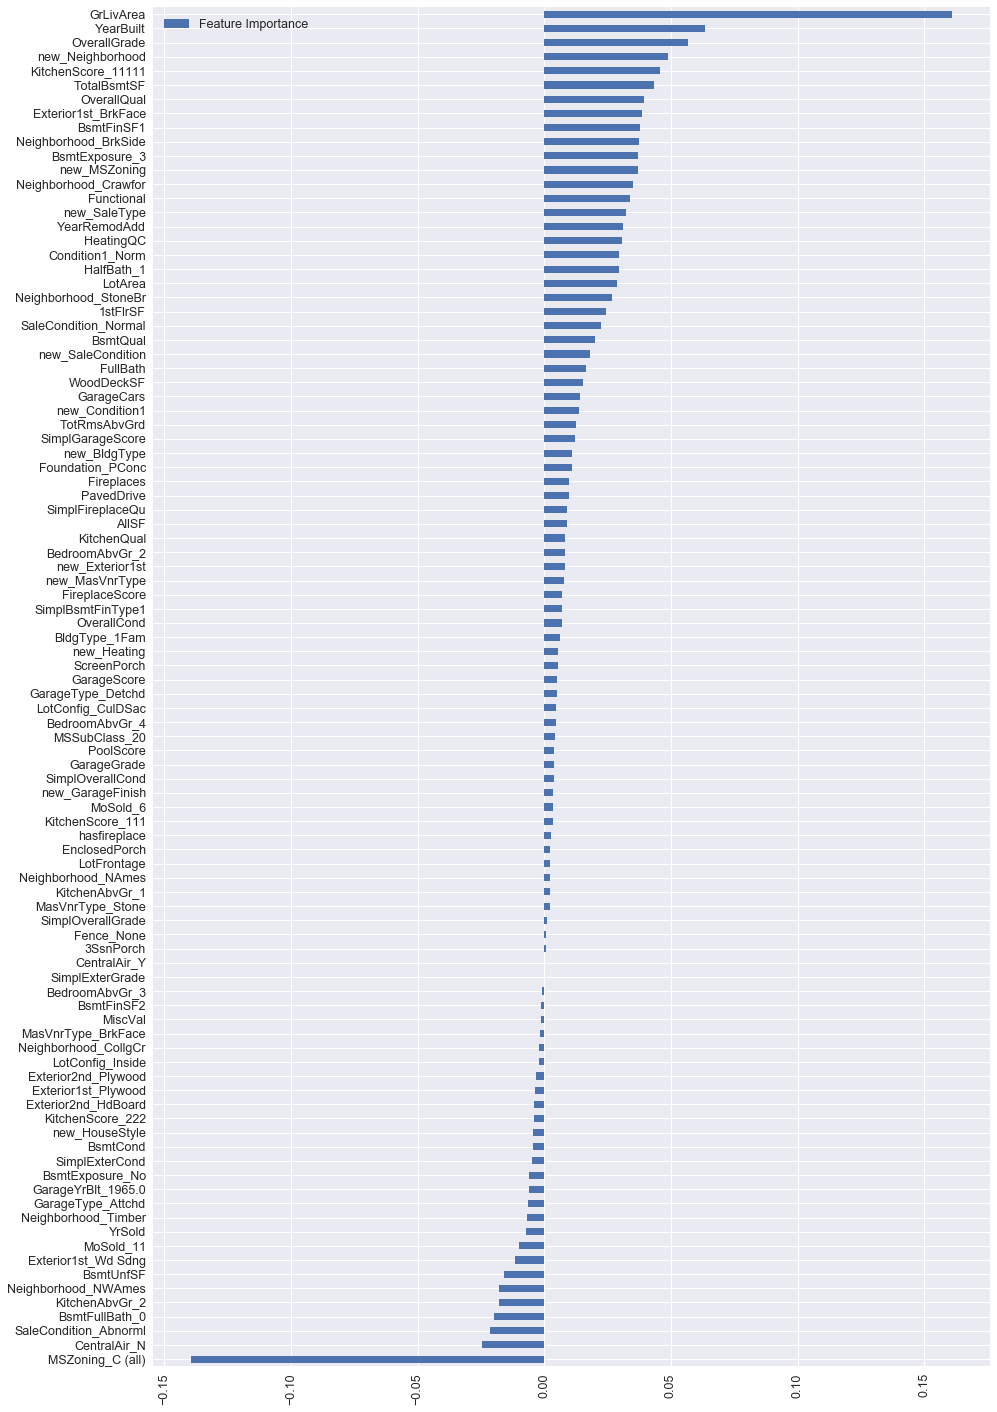

In [40]:
FI_lasso.sort_values("Feature Importance",ascending=False)
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [41]:
def addSquared(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l] ** 2).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 
def addCubed(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l] ** 3).values)   
        res.columns.values[m] = l + '_cu'
        m += 1
    return res 
best_list = ['GrLivArea','YearBuilt','OverallGrade','new_Neighborhood','KitchenScore_11111','TotalBsmtSF','OverallQual','Exterior1st_BrkFace','BsmtFinSF1','Neighborhood_BrkSide','MSZoning_C (all)']


In [42]:
final_data_eq=addSquared(entire_data,best_list)
final_data=addCubed(final_data_eq,best_list)
print(final_data.shape)

(1459, 479)


## 2.9 Removal of outliers

In [43]:
import statsmodels.api as sm

ols = sm.OLS(endog = Y_train, exog = X_train)

fit = ols.fit()
test2 = fit.outlier_test()['bonf(p)']
outliers = list(test2[test2<1e-3].index) 

print (outliers)

final_data.drop(final_data.index[outliers],inplace=True)
final_data.reset_index(drop=True, inplace=True)

log_sp.drop(log_sp.index[outliers],inplace=True)
log_sp.reset_index(drop=True,inplace=True)

Y_train_final=log_sp[:1199-len(outliers)].values

X_train_final=final_data[:1199-len(outliers)]
X_test_final=final_data[1199-len(outliers):]

X_train_final = scaler.fit(X_train_final).transform(X_train_final)
X_test_final = scaler.fit(X_test_final).transform(X_test_final)


[263, 462, 467, 587, 631, 634, 847, 953, 967, 1010, 1186]


#### Comment:
We use the **OLS outlier test** to detect more outliers by fitting the data and remove them.We are only considering values which have bonf(p) less than **1e-3** as outliers.

# 3. Modeling and Validation
* There are many well inplemented regression models availble, To build our model, we decided to choose several of them and the ensemble the result from the chosen models.
* Our idea is that we try models with various algorithms **(like Linear Spuare, Decision tree, Support , Vector regression, etc)**, and select the best ones that can fit our data, and then ensemble than to make our final model.
* When we ensemble them, we would like to choose each from different algorithms to keep the "algorithem diversity" in our ensemble model. Since different algorithm may has it own advantage to fit some certain pattern in our data, we keep these diversity so that our ensemble model can fit more features in our data.
* Kindly note that we have used **bayesian optimization** for tuning hyperparameters of the models and its shown in **part 4 in the end.**

In [46]:
#how we validate the model performance
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train_final)
    rmse = np.sqrt(-cross_val_score(model, X_train_final, Y_train_final, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)
    

### 3.1 Individual model

#### 3.1.1 Lasso

In [47]:
lasso = Lasso(alpha =0.0005, random_state=1)
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1008 (0.0028)



#### 3.1.2 Elastics Net

In [48]:
ENet = ElasticNet(alpha=0.003, l1_ratio=.17, random_state=3)
score = rmsle_cv(ENet)
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ElasticNet score: 0.1010 (0.0027)



#### 3.1.3 Kernel Ridge

In [49]:
KRR = KernelRidge(alpha=0.1042, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("\nKernelRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


KernelRidge score: 0.1018 (0.0037)



#### 3.1.4 SVR

In [50]:
svr =  SVR(kernel="poly", coef0=1.2, degree=2)
score = rmsle_cv(svr)
print("\nSVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


SVR score: 0.1059 (0.0041)



#### 3.1.5 ExtraGradientBoost

In [51]:
model_xgb = XGBRegressor(learning_rate =0.015, n_estimators=2000,max_depth = 4,colsample_bytree = 0.1,nthread = -1,
                             gamma = 0.005, child_weight = 2, scale_pos_weight=1,subsample =0.9, seed=27)

score = rmsle_cv(model_xgb)
print("\nXGB score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


XGB score: 0.1080 (0.0059)



#### 3.1.6 ExtraTreeRegressor

In [52]:
model_extratree = ExtraTreesRegressor(max_depth=10, min_impurity_split=0.02
                                      ,min_weight_fraction_leaf=0.1,n_estimators=50)
score = rmsle_cv(model_extratree)
print("\nmodel_extratree score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


model_extratree score: 0.1974 (0.0159)



#### 3.1.7 Random Forest Regressor

In [53]:
model_randomforest = RandomForestRegressor(max_depth=13, min_samples_split=0.005, n_estimators=1500)
score = rmsle_cv(model_randomforest)
print("\nmodel_randomforest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


model_randomforest score: 0.1310 (0.0080)



#### 3.1.8 Gradient Boosting Regressor

In [58]:
GBoost = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.05,
                                   max_depth=2, max_features='sqrt',
                                   min_samples_split=0.1, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("\nGradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Gradient Boosting score: 0.1084 (0.0054)



#### COMMENT 3.1:

Here we got the baseline of each of the model using tuned parameters we get from the bayesian-optimization, we decided that the baseline is around **0.19 - 0.10**, so when we selecting, **we only choose those model whose RMSE are less than 0.11.** for building a stacked model.



### 3.2 Build a stacked model

In the stacking models part, we added a **meta-model** on top, and use the prediction of base models as features to train it. To be more specific, we first split the total training set into two disjoint sets. Then, we will train several base models on the first set and test these base models on the second one. Finally, we use the predictions from base leaners as inputs to train the meta-model.

In this case, we use the **Lasso** as a **meta model**, **elastic net**, **kernel rigde**, **Support Vector Regression** and **GradientBoost** as base learners. Those models perform very well individually. The reason we choose **Lasso** as a meta model is that Lasso penalizes the regression coefficient to lower their magnitude. The coefficient we got from Lasso can give us the idea of how imporant each base learner is. Besides, Lasso also got the hightest score comparing to the others.


In [59]:
class StackingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5, alpha=0.006):
        
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.alpha = alpha
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])                
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        
        pra = {"alpha": self.alpha}
        self.meta_model_.set_params(**pra)
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
        

In [65]:

stacked_models = StackingModels(base_models = (ENet, KRR, svr ,GBoost),
                                meta_model = Lasso(), alpha=0.0001)


score = rmsle_cv(stacked_models)
print("\nStacked model score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Stacked model score: 0.1004 (0.0035)



The result we got from the stacked model increased a little comparing the each individual one in both **mean** and **variance**.

### 3.3 Averaging stacked models and ExtraGradientBoost

Since **ExtraGradientBoosting** also obtain a quite good result, we decide to go further one more step by averaging out the **stacked model** and **ExtraGradientBoost** base on their performance. The idea is that each model has advantages and disadvantages, and we would like to combine as many as we could. Generalization is a good characteristic to consider when designing a model.

In [74]:
#stacked model prediction
y_stack_pred = np.expm1(stacked_models.fit(X_train_final,Y_train_final).predict(X_test_final))

#gradient boosting prediction
y_gb_pred = np.expm1(model_xgb.fit(X_train_final, Y_train_final).predict(X_test_final))

#weight each model according to its performance
weight_stack = (0.1080)/(0.1004+0.1080)
weight_xgb = 1- weight_stack

#Averaging out the prediction
y_prediction = weight_stack* y_stack_pred+ weight_xgb*y_gb_pred


In [75]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = y_prediction
sub.to_csv('submission.csv',index=False)

# 4. Tuning parameter

How We Design The Tuning Procedure:

We found 3 common tunning methods:**Randomized Parameter Optimization**, **Grid Search**, and **Bayesian Optimization**.

The short point of Randomized method and Grid Search is that  for many model, their parameters has a huge possible range (like [0,∞]), we need to first find out a posible good small interval of value, and give it to Grid Search to compare the best among then. But it is very hard to prior knowledge or gusse what is a interval for each parameter. So we decide to use **Bayesian Optimization** to deal with this problem. Bayesian Optimization built upon bayesian inference and gaussian process, that attempts to find the maximum value of an unknown function in as few iterations as possible.

Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not.This technique is particularly suited for optimization of high cost functions, situations where the balance between exploration and exploitation is important.

**So in our tuning work,we first try to use Bayesian Optimization to find out which regions in parameter space are worth exploring, and then give this interval to Grid Search to compare the best in this interval.**

## 4.1 Tuning hyperparameter for stacked model

In [67]:
def stacked_models_cv(lasso_alpha):
    stacked_models = StackingModels(base_models = (ENet, KRR, svr ,GBoost),
                                    meta_model = Lasso(), alpha=lasso_alpha)
    rmse= np.sqrt(-cross_val_score(stacked_models, X_train_final, Y_train_final, scoring="neg_mean_squared_error", cv = 5))
    return (-rmse.mean())


In [68]:
start = time.time()
gp_params = {"alpha": 1e-7}

averagedBO = BayesianOptimization(stacked_models_cv,{"lasso_alpha": (0.0001, 1)})

averagedBO.explore({"lasso_alpha": [0.005,0.006]})

averagedBO.maximize(n_iter=10, **gp_params)
print (time.time()-start)

Initialization
---------------------------------------------
 Step |   Time |      Value |   lasso_alpha | 
    1 | 01m33s |   -0.10154 |        0.0050 | 
    2 | 01m37s |   -0.10198 |        0.0060 | 
    3 | 01m33s |   -0.39989 |        0.6276 | 
    4 | 01m33s |   -0.39989 |        0.6973 | 
    5 | 01m40s |   -0.20458 |        0.0683 | 
    6 | 01m35s |   -0.39989 |        0.9709 | 
    7 | 01m34s |   -0.17266 |        0.0535 | 
Bayesian Optimization
---------------------------------------------
 Step |   Time |      Value |   lasso_alpha | 
    8 | 01m38s |   -0.10038 |        0.0001 | 
    9 | 01m33s |   -0.39989 |        0.3737 | 
   10 | 01m35s |   -0.10038 |        0.0001 | 
   11 | 01m42s |   -0.10038 |        0.0001 | 
   12 | 01m45s |   -0.10038 |        0.0001 | 
   13 | 01m47s |   -0.10038 |        0.0001 | 
   14 | 01m44s |   -0.10038 |        0.0001 | 
   15 | 01m48s |   -0.10038 |        0.0001 | 
   16 | 01m40s |   -0.10038 |        0.0002 | 
   17 | 01m41s |   -0.100

## 4.2 Tuning Basic Models

In [69]:
#GridSearchCV tuning function
def Grid_Search(model, parameters):
    GS_model = GridSearchCV(estimator = model, param_grid = parameters, scoring= 'neg_mean_squared_error',
                            cv = KFold(n_splits= 5, random_state= 42, shuffle=True))
    GS_model.fit(X_train_final, Y_train_final)

    print("Best score (transform to RMSE): %0.3f" % np.sqrt(-GS_model.best_score_))
    print("Best parameters set:")
    best_parameters = GS_model.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [72]:
#Bayesian Optimization tuning function
def CV_function(model):
    val = np.sqrt(-cross_val_score(
        make_pipeline(RobustScaler(), model),
        X_train_final, Y_train_final, scoring='neg_mean_squared_error', cv=5, n_jobs=-1
    )).mean()
    return -val

gp_params = {"alpha": 1e-5}
def  Bayesian_Optimization(model, regions_params, explore_params, n_iter = 30):
    model_BO = BayesianOptimization(model,{'alpha': (0.0005, 1)})
    model_BO.explore()
    model_BO.maximize(n_iter = n_iter, **gp_params, acq='ucb', kappa=5)
    return model_BO

### 4.2.1 Tuning lasso
* The lasso has only one key parameter alpha for tuning alpha

* Where **alpha** controls the “mix” of ridge and lasso regularisation, with **alpha=0 being “pure” ridge and alpha=1 being “pure” lasso.**

* In lasso model a very tiny alpha value means it more like a ordinary least squares models. **so here we set the bayesian optimization to explore range as [1, 0.0005], and then use GridSearch to search in the found smaller interval.**

In [ ]:
# BayesianOptimization tuning lasso
def bayestuning_lasso(alpha):
    val = CV_function(Lasso(alpha = alpha))
    return val

regions_params = {'alpha': (0.0005, 1)}
explore_params = {'alpha': [0.0005,0.001,0.005, 0.01,0.05, 0.1,0.5, 1]}
model_BO = Bayesian_Optimization(bayestuning_lasso)

Initialization
-----------------------------------------
 Step |   Time |      Value |     alpha | 
    1 | 00m01s |   -0.10063 |    0.0005 | 
    2 | 00m01s |   -0.10282 |    0.0010 | 
    3 | 00m01s |   -0.11083 |    0.0050 | 
    4 | 00m01s |   -0.11723 |    0.0100 | 
    5 | 00m01s |   -0.16479 |    0.0500 | 
    6 | 00m00s |   -0.22019 |    0.1000 | 
    7 | 00m00s |   -0.39955 |    0.5000 | 
    8 | 00m00s |   -0.39955 |    1.0000 | 
    9 | 00m00s |   -0.39955 |    0.6343 | 
   10 | 00m00s |   -0.39955 |    0.5406 | 
   11 | 00m00s |   -0.38530 |    0.2803 | 
   12 | 00m00s |   -0.39955 |    0.5553 | 
   13 | 00m00s |   -0.39955 |    0.7744 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |     alpha | 
   14 | 00m12s |   -0.10063 |    0.0005 | 
   15 | 00m09s |   -0.39955 |    0.6745 | Warning: Test point chose at random due to repeated sample.

   16 | 00m11s |   -0.10063 |    0.0005 | 
   17 | 00m28s |   -0.10063 |    0.0005 | 
  

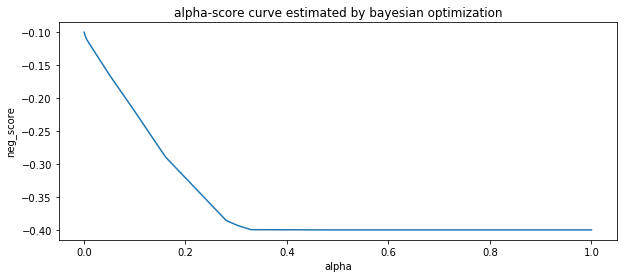

In [33]:
# ploting Bayesian_Optimization exploring result
with open("foo.csv", "w") as my_empty_csv:
  # 
  pass  # 
model_BO.points_to_csv("foo.csv")
tuning_result =  pd.read_csv("foo.csv")
tuning_result = tuning_result.sort_values(by=[tuning_result.columns[0]])
plt.figure(figsize = (10, 4))
plt.plot(tuning_result[tuning_result.columns[0]],tuning_result[tuning_result.columns[1]])
plt.xlabel('alpha')
plt.ylabel('neg_score')
plt.title('alpha-score curve estimated by bayesian optimization')
plt.show()

**note:** since the BayesianOptimization try to maximize the objective function, we transforn RMSE score to neg_RMSE_score to find the minimum value of CV_error

In [100]:
# GridSearchCV tuing lasso
parameters = {'Lasso__alpha':[0.0001, 0.0002, 0.0003,0.0004,0.0005,0.0007,0.0008]}
lasso = Pipeline([("Scaler", RobustScaler()), ("Lasso", Lasso(random_state=42,max_iter=1e5))])
Grid_Search(lasso,parameters)

Best score (transform to RMSE): 0.104
Best parameters set:
	Lasso__alpha: 0.0005


#### COMMENT:

After BayesianOptimization we can find that the best region of alpha maybe very tiny. **But a very tiny alpha will lead the model more like ordinary least square OLS, so we decide to keep alpha small but not to close to zero, so we decide the interval to give to GridSearch is [0.0001,0.0008] with step of 0.0001.** Throught BayesianOptimization we find out a small region of alpha to give to GridSearch. 

And final get the best alpha in our case as **0.0005**.

### 4.2.2 Tuning KernelRidge

KRR combines ridge regression with the kernel trick which we allow to have hyper degree coefficient. But by looking at the scatter plot in Data exploration, we find that most features may have the highest degree as 2 in the relationship against saleprice, so we fix the parameter of degree as 2, only tuning the alpha with BayesianOptimization and GridSearch. 


In [105]:
# BayesianOptimization for KRR
def bayestuning_KernelRidge(alpha):
    val = CV_function(KernelRidge(alpha=alpha, kernel='polynomial', degree=2))
    return val

regions_params = {'alpha': (1e-04, 0.8)}
explore_params = {'alpha': [0.8,0.0001, 0.8,0.001] }
model_BO = Bayesian_Optimization(bayestuning_KernelRidge)

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |     alpha | 
   15 | 00m18s |   -0.10549 |    0.4355 | 
   16 | 00m14s |   -0.10332 |    0.2885 | 
   17 | 00m20s |   -0.10144 |    0.1541 | 
   18 | 00m18s |   -0.10187 |    0.1870 | 
   19 | 00m25s |   -0.10107 |    0.1193 | 


/usr/local/lib/python3.5/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'grad': array([3.34098122e-05]), 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46}
  " state: %s" % convergence_dict)


   20 | 00m30s |   -0.10377 |    0.3189 | 
   21 | 00m33s |   -0.10194 |    0.1927 | 
   22 | 00m30s |   -0.10108 |    0.1197 | 
   23 | 00m29s |   -0.10112 |    0.1242 | 
   24 | 00m28s |   -0.10217 |    0.2089 | 
   25 | 00m44s |   -0.10656 |    0.5094 | Warning: Test point chose at random due to repeated sample.

   26 | 00m43s |   -0.10098 |    0.0688 | Warning: Test point chose at random due to repeated sample.

   27 | 00m54s |   -0.10851 |    0.6452 | 
   28 | 00m50s |   -0.10096 |    0.1042 | 
   29 | 01m04s |   -0.10440 |    0.3619 | 
   30 | 01m13s |   -0.10099 |    0.1080 | 
   31 | 01m05s |   -0.11066 |    0.8000 | 
   32 | 01m03s |   -0.10101 |    0.1116 | 
   33 | 01m39s |   -0.10142 |    0.1519 | 
   34 | 01m40s |   -0.10296 |    0.2641 | 
   35 | 01m24s |   -0.10099 |    0.1086 | 
   36 | 01m38s |   -0.10549 |    0.4358 | 
   37 | 01m23s |   -0.10154 |    0.1618 | 
   38 | 01m11s |   -0.10099 |    0.1080 | 
   39 | 01m34s |   -0.10157 |    0.1642 | 


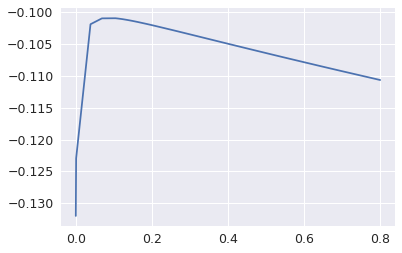

In [110]:
# create a new file save BayesianOptimization result
with open("foo.csv", "w") as my_empty_csv:
  # 
  pass  # 
model_BO.points_to_csv("foo.csv")
tuning_result =  pd.read_csv("foo.csv")
tuning_result = tuning_result.sort_values(by=[tuning_result.columns[0]])
plt.plot(tuning_result[tuning_result.columns[0]],tuning_result[tuning_result.columns[1]])
plt.show()

In [108]:
# GridSearchCV tuing KernelRidge
parameters = {'KernelRidge__alpha':[0.006,0.03,0.05,0.07,0.09,0.11,0.13, 0.15]}
model = Pipeline([("Scaler", RobustScaler()), ("KernelRidge", KernelRidge(kernel='polynomial', degree=2,))])
Grid_Search(model,parameters)

Best score (transform to RMSE): 0.104
Best parameters set:
	KernelRidge__alpha: 0.11


#### COMMENT:
Like in lasso, via BayesianOptimization we find the best region of alpha lies on**[0.006, 0.15]**

And then use GridSearchCV find out the best parameters.

### 4.2.3 Tuning ElasticNet

The ElasticNet has two key parameter alpha and l1_ratio, so we just using 50 iterations.

``alpha = 0`` is equivalent to an ordinary least square, solved by the LinearRegression object. For numerical reasons, using alpha = 0 with the Lasso object is not advised.

The ElasticNet mixing parameter, with **0 <= l1_ratio <= 1**. For l1_ratio = 0 the penalty is an L2 penalty. 

In [ ]:
# BayesianOptimization for ElasticNet
def bayestuning_ElasticNet(alpha, l1_ratio):
    val = CV_function(ElasticNet(alpha = alpha,l1_ratio =l1_ratio,max_iter=1e5))
    return val

regions_params = {'alpha': (0.0001, 0.01), 'l1_ratio': (0.001,1)}
explore_params = {'alpha': [0.01,0.001,0.01,0.001, 0.1], 'l1_ratio': [0.001, 0.001, 1, 1,0.1]}
model_BO = Bayesian_Optimization(bayestuning_ElasticNet)

Initialization
------------------------------------------------------
 Step |   Time |      Value |     alpha |   l1_ratio | 
    1 | 00m03s |   -0.10232 |    0.0100 |     0.0010 | 
    2 | 00m18s |   -0.11297 |    0.0010 |     0.0010 | 
    3 | 00m01s |   -0.11721 |    0.0100 |     1.0000 | 
    4 | 00m02s |   -0.10280 |    0.0010 |     1.0000 | 
    5 | 00m01s |   -0.12029 |    0.1000 |     0.1000 | 
    6 | 00m01s |   -0.10268 |    0.0018 |     0.5288 | 
    7 | 00m01s |   -0.10718 |    0.0070 |     0.3073 | 
    8 | 00m02s |   -0.10049 |    0.0012 |     0.3633 | 
    9 | 00m01s |   -0.10354 |    0.0025 |     0.4615 | 
   10 | 00m01s |   -0.10185 |    0.0015 |     0.5373 | 
Bayesian Optimization
------------------------------------------------------
 Step |   Time |      Value |     alpha |   l1_ratio | 
   11 | 02m46s |   -0.12573 |    0.0001 |     0.0010 | 
   12 | 00m59s |   -0.11048 |    0.0001 |     0.6025 | 
   13 | 01m21s |   -0.11081 |    0.0001 |     0.5754 | 
   14 | 01m18

In [87]:
# GridSearchCV tuing ElasticNet
parameters = {'ElasticNet__alpha':[0.0025, 0.003,0.0035], 'ElasticNet__l1_ratio':[0.13,0.14, 0.15, 0.16, 0.17]}
model = Pipeline([("Scaler", RobustScaler()), ("ElasticNet", ElasticNet(random_state=42, max_iter=1e5))])
Grid_Search(model,parameters)

Best score (transform to RMSE): 0.103
Best parameters set:
	ElasticNet__alpha: 0.003
	ElasticNet__l1_ratio: 0.17


#### COMMENT:

Via BayesianOptimization we find the best region of 
* **alpha** lies on   [0.0001, 0.01]
* **l1_ratio** lies on [0.001,1]

### 4.2.4 Tuning BayesianRidge
the BayesianRidge has four key parameter to set:

alpha_1, alpha_2, lambda_1, lambda_2, all of then are around **1e-06**

In [108]:
def bayestuning_BayesianRidge(alpha_1, alpha_2, lambda_1, lambda_2):
    val = np.sqrt(-cross_val_score(
        make_pipeline(RobustScaler(), BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2, lambda_1=lambda_1, lambda_2=lambda_2)),
        X_train_final, Y_train_final, scoring='neg_mean_squared_error', cv=5, n_jobs=-1
    )).mean()
    return -val

model_BO = BayesianOptimization(bayestuning_BayesianRidge,{'alpha_1': (1e-07, 0.001),'alpha_2': (1e-07, 0.001),'lambda_1': (1e-07, 0.001),'lambda_2': (1e-07, 0.001)})



### 4.2.5 Tuning ExtraTreesRegressor

Since some key parameter in ExtraTreesRegressor like **max_depth** and **min_samples_split** are discrete, which not suitable for the **Bayesian_Optimization** function we choose(need continuity interval), and **ExtraTreesRegressor** have a many parameters that can be tuning, so we decide to read some documents find some empirical range for some key parameters, and using **GridSearchCV** to search for then.

In [117]:
# GridSearchCV tuing ExtraTreesRegressor
parameters = {'ExtraTreesRegressor__n_estimators':[ 10,50, 100, 200, 300],
              'ExtraTreesRegressor__max_depth':[5, 10, 15, 20], 
              'ExtraTreesRegressor__min_samples_split':[0.02, 0.04, 0.06, 0.1, 0.2, 0.4],
             "ExtraTreesRegressor__min_weight_fraction_leaf":[0.1,0.2,0.4,]}
model = Pipeline([("Scaler", RobustScaler()), ("ExtraTreesRegressor", ExtraTreesRegressor())])
Grid_Search(model,parameters)

Best score (transform to RMSE): 0.197
Best parameters set:
	ExtraTreesRegressor__max_depth: 10
	ExtraTreesRegressor__min_samples_split: 0.02
	ExtraTreesRegressor__min_weight_fraction_leaf: 0.1
	ExtraTreesRegressor__n_estimators: 50


### 4.2.6 Tuning Randomforest

The same as tuning ExtraTreesRegressor, we try to find some empirical range for some key parameters, and using **GridSearchCV** to search for then.

In [118]:
# GridSearchCV tuing RandomForestRegressor
parameters = {'RandomForestRegressor__n_estimators':[ 10, 100, 1000, 2000],
              'RandomForestRegressor__max_depth':[5, 10, 15, 20], 
              'RandomForestRegressor__min_samples_split':[0.02, 0.03, 0.04, 0.05, 0.07, 0.1, 0.2]}
model = Pipeline([("Scaler", RobustScaler()), ("RandomForestRegressor", RandomForestRegressor())])
Grid_Search(model,parameters)

Best score (transform to RMSE): 0.139
Best parameters set:
	RandomForestRegressor__max_depth: 15
	RandomForestRegressor__min_samples_split: 0.02
	RandomForestRegressor__n_estimators: 1000


### 4.2.7 Tuning GradientBoostingRegressor,

In [64]:
parameters = {'GradientBoostingRegressor__learning_rate':[0.05, 0.1, 0.5,1],
              'GradientBoostingRegressor__max_depth':[2,4,6,9], 
              'GradientBoostingRegressor__min_samples_split':[0.03,0.07,0.1,0.3]}
model = Pipeline([("Scaler", RobustScaler()), ("GradientBoostingRegressor", GradientBoostingRegressor(
Grid_Search(model,parameters)

Best score (transform to RMSE): 0.112
Best parameters set:
	GradientBoostingRegressor__learning_rate: 0.05
	GradientBoostingRegressor__max_depth: 2
	GradientBoostingRegressor__min_samples_split: 0.1


### 4.2.8 Tuning Xgboot

The key parameter in xgboot are the **max_depth** and **min_samples_split** 
these two control the **overfit** and **performance**.

In [115]:
parameters = {
 'xgb__max_depth':[2, 4, 5, 6, 8],
 'xgb__min_child_weight':[1,2,4,6]
}

model = Pipeline([("Scaler", RobustScaler()), ("xgb", xgb.XGBRegressor(learning_rate =0.1, n_estimators=2000,
    gamma=0, subsample=0.8, colsample_bytree=0.8,scale_pos_weight=1, seed=27))])

Grid_Search(model,parameters)

Best score (transform to RMSE): 0.111
	xgb__max_depth: 4
	xgb__min_child_weight: 2


In [114]:
parameters = {
 'xgb__colsample_bytree':[0.1, 0.01,0.05],
 'xgb__subsample':[1.2,1.5, 0.9],
#  'xgb__gamma':[0.1, 0.05, 0.01],   
}

model = Pipeline([("Scaler", RobustScaler()), ("xgb", xgb.XGBRegressor(learning_rate =0.1, n_estimators=2000,max_depth = 4,
    child_weight = 2, scale_pos_weight=1, seed=27))])
Grid_Search(model,parameters)

Best score (transform to RMSE): 0.111
	xgb__colsample_bytree: 0.1
	xgb__subsample: 0.9


In [112]:
parameters = {
 'xgb__learning_rate':[0.01, 0.02,0.015],
 'xgb__gamma':[0.005, 0.008, 0.01],
}

model = Pipeline([("Scaler", RobustScaler()), ("xgb", xgb.XGBRegressor(learning_rate =0.1, n_estimators=2000,max_depth = 4,colsample_bytree = 0.1,
    child_weight = 2, scale_pos_weight=1,subsample =0.9, seed=27))])
Grid_Search(model,parameters)

Best score (transform to RMSE): 0.106
	xgb__gamma: 0.005
	xgb__learning_rate: 0.015


### Tuning SRV

In [111]:
parameters = {
 'SVR__degree':[1,2,3,4],
 'SVR__coef0':[1, 1.2, 1.5, 3.7, 0.9]   
}

model = Pipeline([("Scaler", RobustScaler()), ("SVR", SVR(kernel ='poly'))])
Grid_Search(model,parameters)

Best score (transform to RMSE): 0.106
	SVR__coef0: 1.2
	SVR__degree: 2
